In [27]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import astropy
from astropy.io import fits
import os
from astropy.timeseries import LombScargle
import glob
import pathlib
from astroquery.mast import Observations
from astropy import units as u
import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'white'
from astropy.coordinates import SkyCoord
from tqdm import tqdm
import pickle
import lightkurve as lk
import scipy.stats as stats
import traceback
from scipy.signal import find_peaks
from IPython.display import Image, display
import scipy
from astropy import constants as const
# import exoplanet as xo

In [20]:
m_dwarf_sample = pd.read_csv('/Users/caleb/research/Astro_98/m_dwarf_sample_with_files_powers.csv',delimiter=',',index_col=0)
ra = np.array(m_dwarf_sample[m_dwarf_sample.columns[0]])
dec = np.array(m_dwarf_sample[m_dwarf_sample.columns[1]])
names = np.array(m_dwarf_sample[m_dwarf_sample.columns[2]])
masses = np.array(m_dwarf_sample[["Mass"]])

In [239]:
names[10]

'G 172-1'

In [21]:
def process(lc,smooth_size): 
    # flatten and remove flares
    clean_lc = lc.remove_nans().remove_outliers(3)
    clean_lc.plot()
    ppm_unit = clean_lc.flux[0].unit
    flat_lc, trend_lc = clean_lc.flatten(window_length=smooth_size, polyorder=2, return_trend=True, break_tolerance=5, niters=3, sigma=3)
    flat_lc = flat_lc.remove_outliers(3)
    # residuals = np.array(clean_lc.flux)-np.array(trend_lc.flux)
    # flat_lc['flux'] = residuals
    flat_lc['flux'] = (flat_lc['flux']-1)*ppm_unit*10**6
    # flat_lc = flat_lc.remove_outliers(3)
    # get perio
    # frequency = np.arange(1, 4000,0.008)
    flat_lc.plot()

    perio = flat_lc.to_periodogram(method='lombscargle',frequency=np.arange(2, 2160,0.008)).smooth(filter_width=2)
    threshold =  4*np.mean(np.array(perio.power))
    threshold_freq = [(i*10**6)/(24*60*60) for i in np.array(perio.smooth(filter_width=20).frequency)]
    # perio = perio.smooth(filter_width=2)
    perio_psd = flat_lc.to_periodogram(method='lombscargle',frequency=np.arange(20, 20000,1),normalization='psd').smooth(filter_width=2)

    # get thresholds

    # flat_lc.to_periodogram(method='lombscargle',frequency=np.arange(2, 2160,0.008)).plot()
    # plt.axhline(y=threshold,color='red')
    # plt.show()
    perio_psd.plot(scale='log')
    plt.show()
    
    frequency_hz = [(i*10**6)/(24*60*60) for i in np.arange(2, 2160,0.008)]
    # indices
    plt.figure(figsize=(10,5))
    plt.plot(frequency_hz,np.array(flat_lc.to_periodogram(method='lombscargle',frequency=np.arange(2, 2160,0.008)).power),color='black',alpha=.8)
    plt.xlabel("Frequency [uHz]",fontsize=15)
    plt.ylabel("Amp. [ppm]",fontsize=15)
    plt.axhline(y=threshold,color='red')
    plt.tick_params(labelsize=10)
    # plt.xscale('log')
    plt.show()
    print('max',frequency_hz[np.argmax(np.array(perio.power))])
    return perio, perio_psd, threshold

In [41]:
modes = np.loadtxt('/Users/caleb/Downloads/AADG3-v3.0.2/examples/s4tess_llrgb/s4tess_llrgb.con')

In [91]:
max([i[4] for i in modes])

136.18829

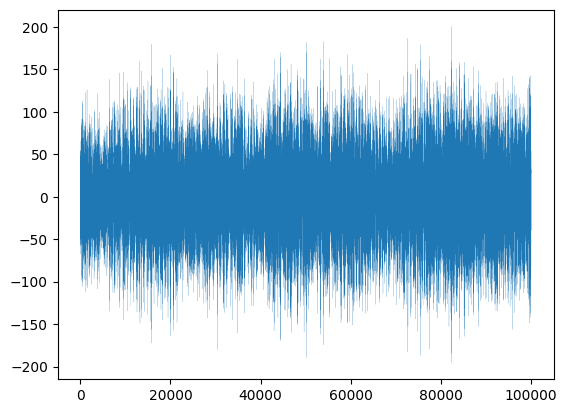

In [22]:
ascii_grid = np.loadtxt("/Users/caleb/downloads/AADG3-v3.0.2/examples/s4tess_llrgb/s4tess_llrgb.asc")
len(ascii_grid)
plt.plot(ascii_grid,linewidth=.1)

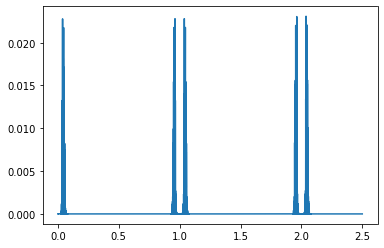

In [11]:
t=np.arange(0,len(ascii_grid),1)
frequency, power = LombScargle(t, ascii_grid).autopower()
plt.plot(frequency,power)

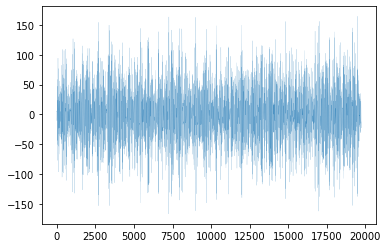

In [16]:
no_gran_ascii_grid = np.loadtxt("/Users/caleb/downloads/AADG3-v3.0.2/examples/s4tess_llrgb/no_gran_s4tess_llrgb.asc")
len(no_gran_ascii_grid)
plt.plot(no_gran_ascii_grid,linewidth=.1)
ascii_grid = no_gran_ascii_grid

In [37]:
def get_fake_lc(lc,amp,smooth_size):
    lc = lc.normalize(unit='ppm')
    lc.plot()
    plt.show()
    rand = np.random.default_rng(42)
    clean_lc = lc.remove_nans().remove_outliers(3)
    clean_lc = clean_lc[:len(ascii_grid)]

    # clean_lc.plot()
    ppm_unit = clean_lc.flux.unit
        # lc['flux'] = (noise+baseline)
    clean_lc['flux'] = clean_lc['flux'] + amp*ascii_grid*ppm_unit


    # just_osc_lc = clean_lc
    # just_osc_lc.flux = amp*ascii_grid*ppm_unit


    # just_osc_lc.plot()
    # plt.title(f"Scaled by {amp}")
    # plt.show()
    # just_osc_lc_perio = just_osc_lc.to_periodogram(method='lombscargle',frequency=np.arange(2, 2160,0.008)).smooth(filter_width=2)
    # just_osc_lc_perio.plot()
    # plt.show()



    flat_lc, trend_lc = clean_lc.flatten(window_length=smooth_size, polyorder=2, return_trend=True, break_tolerance=5, niters=3, sigma=3)

    flat_lc = flat_lc.remove_outliers(3)
    # residuals = np.array(clean_lc.flux)-np.array(trend_lc.flux)
    # flat_lc['flux'] = residuals
    flat_lc['flux'] = (flat_lc['flux'])*ppm_unit*10**6

    clean_lc = flat_lc

    # noise = np.std((clean_lc['flux'])) * np.random.normal(size=len(t))
    # baseline = np.mean((clean_lc['flux']))

    return clean_lc, ppm_unit

In [17]:
# load the time stamps of a TESS observation
row = 10
lcf = lk.search_lightcurve('Gaia DR3  240259375324767744', mission='TESS',exptime=20).download()
lc = lcf.PDCSAP_FLUX.remove_nans()

/var/folders/8w/z7zsz3tj76jd_p19pfzbwj5c0000gn/T/ipykernel_58255/2711936640.py:4: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  lc = lcf.PDCSAP_FLUX.remove_nans()


In [24]:
def get_gaussian_lc(lc):
    rand = np.random.default_rng(42)
    lc = lc.remove_nans()
    t = lc.time.value
    clean_lc = lc.remove_outliers(4)


    noise = np.std((clean_lc['flux'])) * np.random.normal(size=len(t))
    baseline = np.mean((clean_lc['flux']))


    lc['flux'] = (noise+baseline)

    return lc

In [25]:
def inject_oscillations(amp,show,num,smooth_size,fake):


    perios = []
    perio_psds = []
    flats = []

    for i in range(num):
        if fake:
            gaussian_lc = get_gaussian_lc(lc)
        else:
            gaussian_lc= lc
        fake_lc,ppm_unit = get_fake_lc(gaussian_lc,amp,smooth_size)
        perio = fake_lc.to_periodogram(method='lombscargle',frequency=np.arange(2, 2160,0.008)).smooth(filter_width=2)
        perio_psd = fake_lc.to_periodogram(method='lombscargle',frequency=np.arange(20, 20000,.1),normalization='psd')
        flat = perio_psd.flatten()
        flat_unit = flat.power.unit

        flat_perio = perio.flatten()
        print(perio.power)

        perios.append(np.array(perio.power))
        perio_psds.append(np.array(perio_psd.power))
        flats.append(np.array(flat.power))


    perio.power = sum(perios)*ppm_unit
    perio_psd.power = sum(perio_psds)*ppm_unit
    flat.power = sum(flats)*flat_unit

    perio_psd = perio_psd.smooth(filter_width=10)

    summed_flat = perio_psd.flatten()

    if show:
        fig, axs = plt.subplots(3,2,figsize=(20,15))
        lc.plot(ax=axs[0][0],color='black',alpha=.8)
        fake_lc.plot(ax=axs[0][1],color='black',alpha=.8)

        perio.plot(ax=axs[1][0],color='black',alpha=.8)
        max_index = [np.round(i,2) for i in list(np.arange(20, 20000,.1))].index(2200)
        # max_index = 2200

        perio_psd.plot(ax=axs[1][1],color='black',alpha=.8,scale='log')

        perio_psd[max_index-int(.3*max_index):max_index+int(.3*max_index)].plot(ax=axs[2][0],color='black',alpha=.8)

        flat.plot(ax=axs[2][1],color='black',alpha=.8)

        axs[0][0].set_title('Original Lightcurve')
        axs[0][1].set_title('Normalized Light Curve')
        axs[1][0].set_title('Power Spectrum')
        axs[1][1].set_title('PSD')
        axs[2][0].set_title('Zoomed-In Oscillations')
        axs[2][1].set_title('Flattened PSD')


        plt.suptitle(f"Injected Oscillations Amplitude = {amp} ppm",fontsize=30)

        plt.subplots_adjust(hspace=.5)
        plt.show()

        

    fig, ax = plt.subplots(1, 1,figsize=(20,10))
    summed_flat.plot(ax=ax,color='black',alpha=.8)
    plt.show()


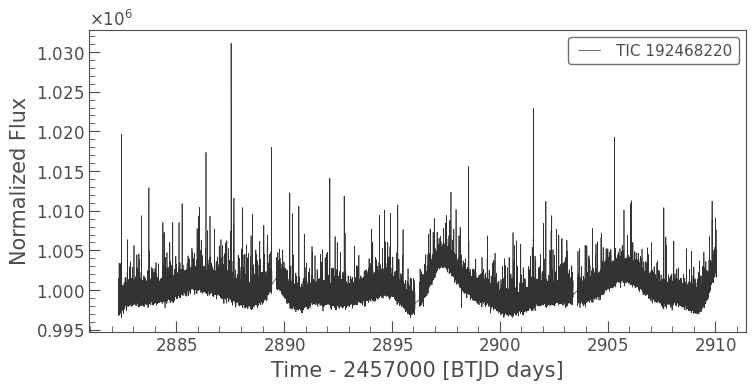

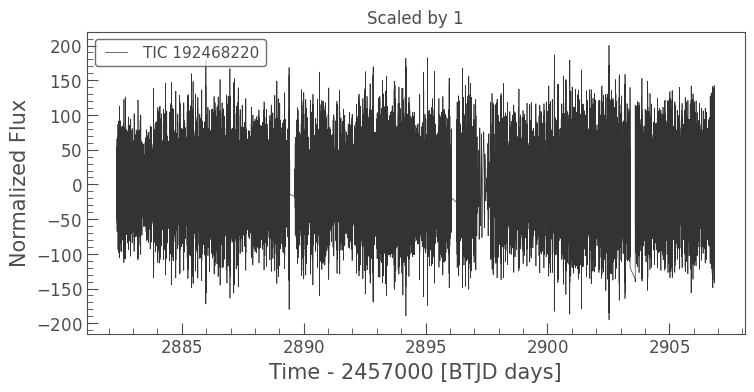

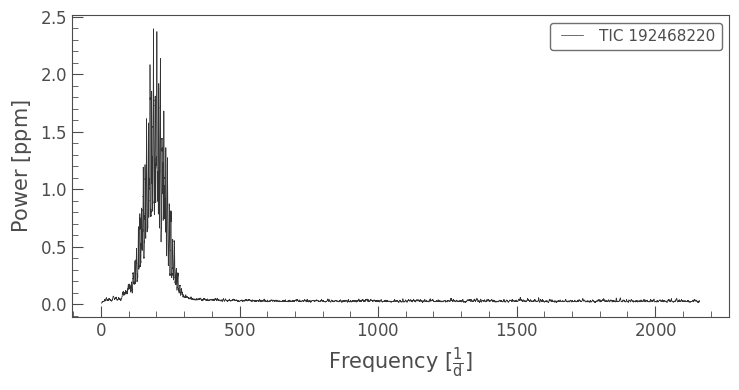

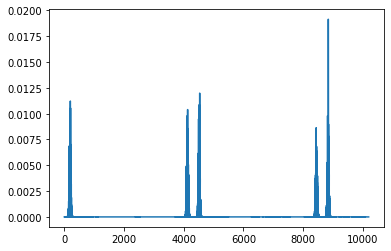

[1992480.33377471 2001431.47055536 2009508.59991439 ...  613656.69591169
  608186.78879453  602686.18942276] ppm2


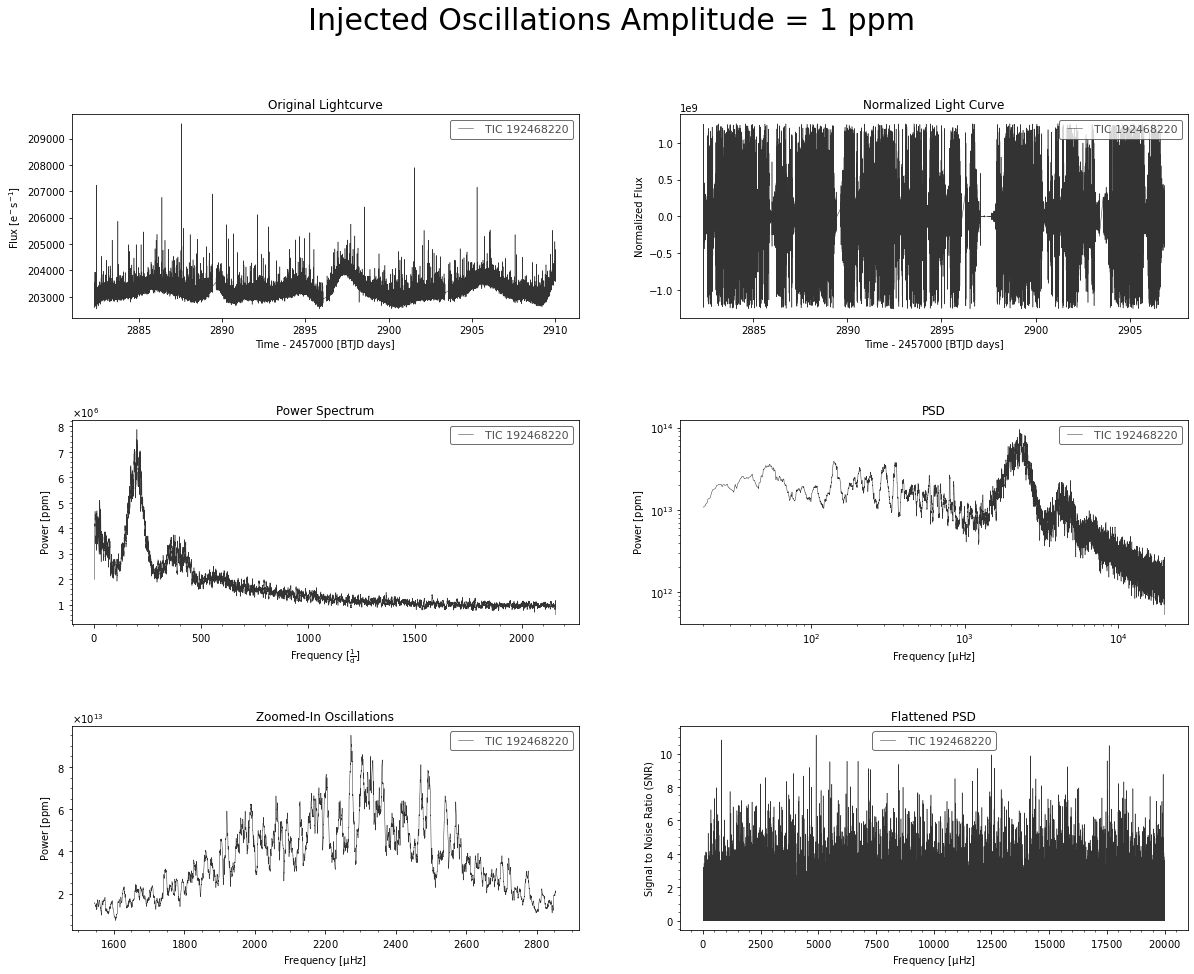

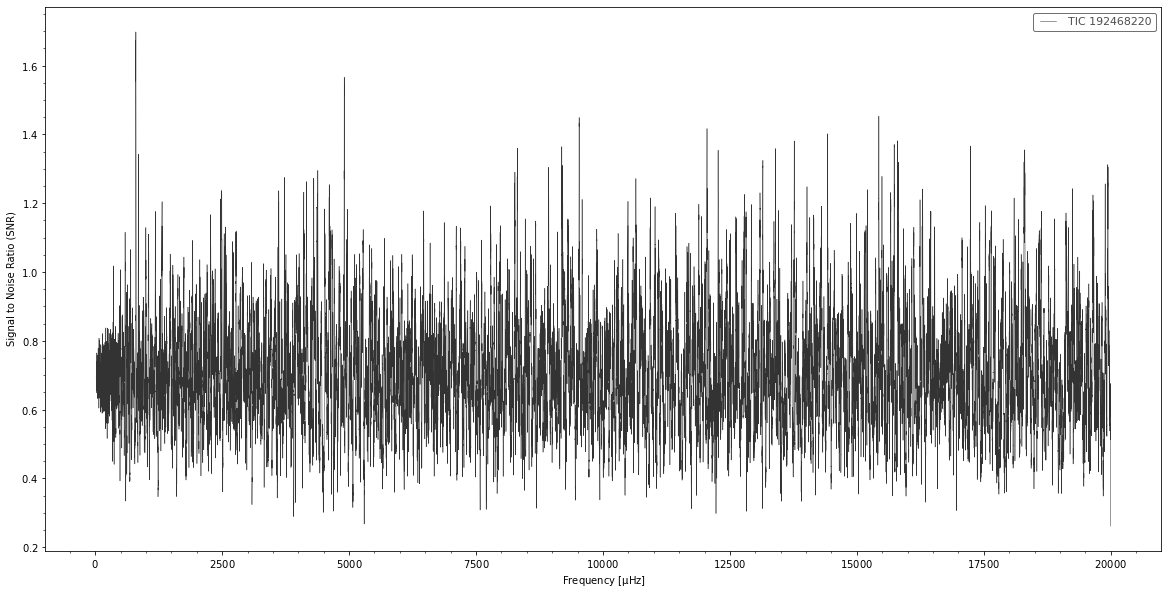

In [58]:
inject_oscillations(1,True,1,2001,False)

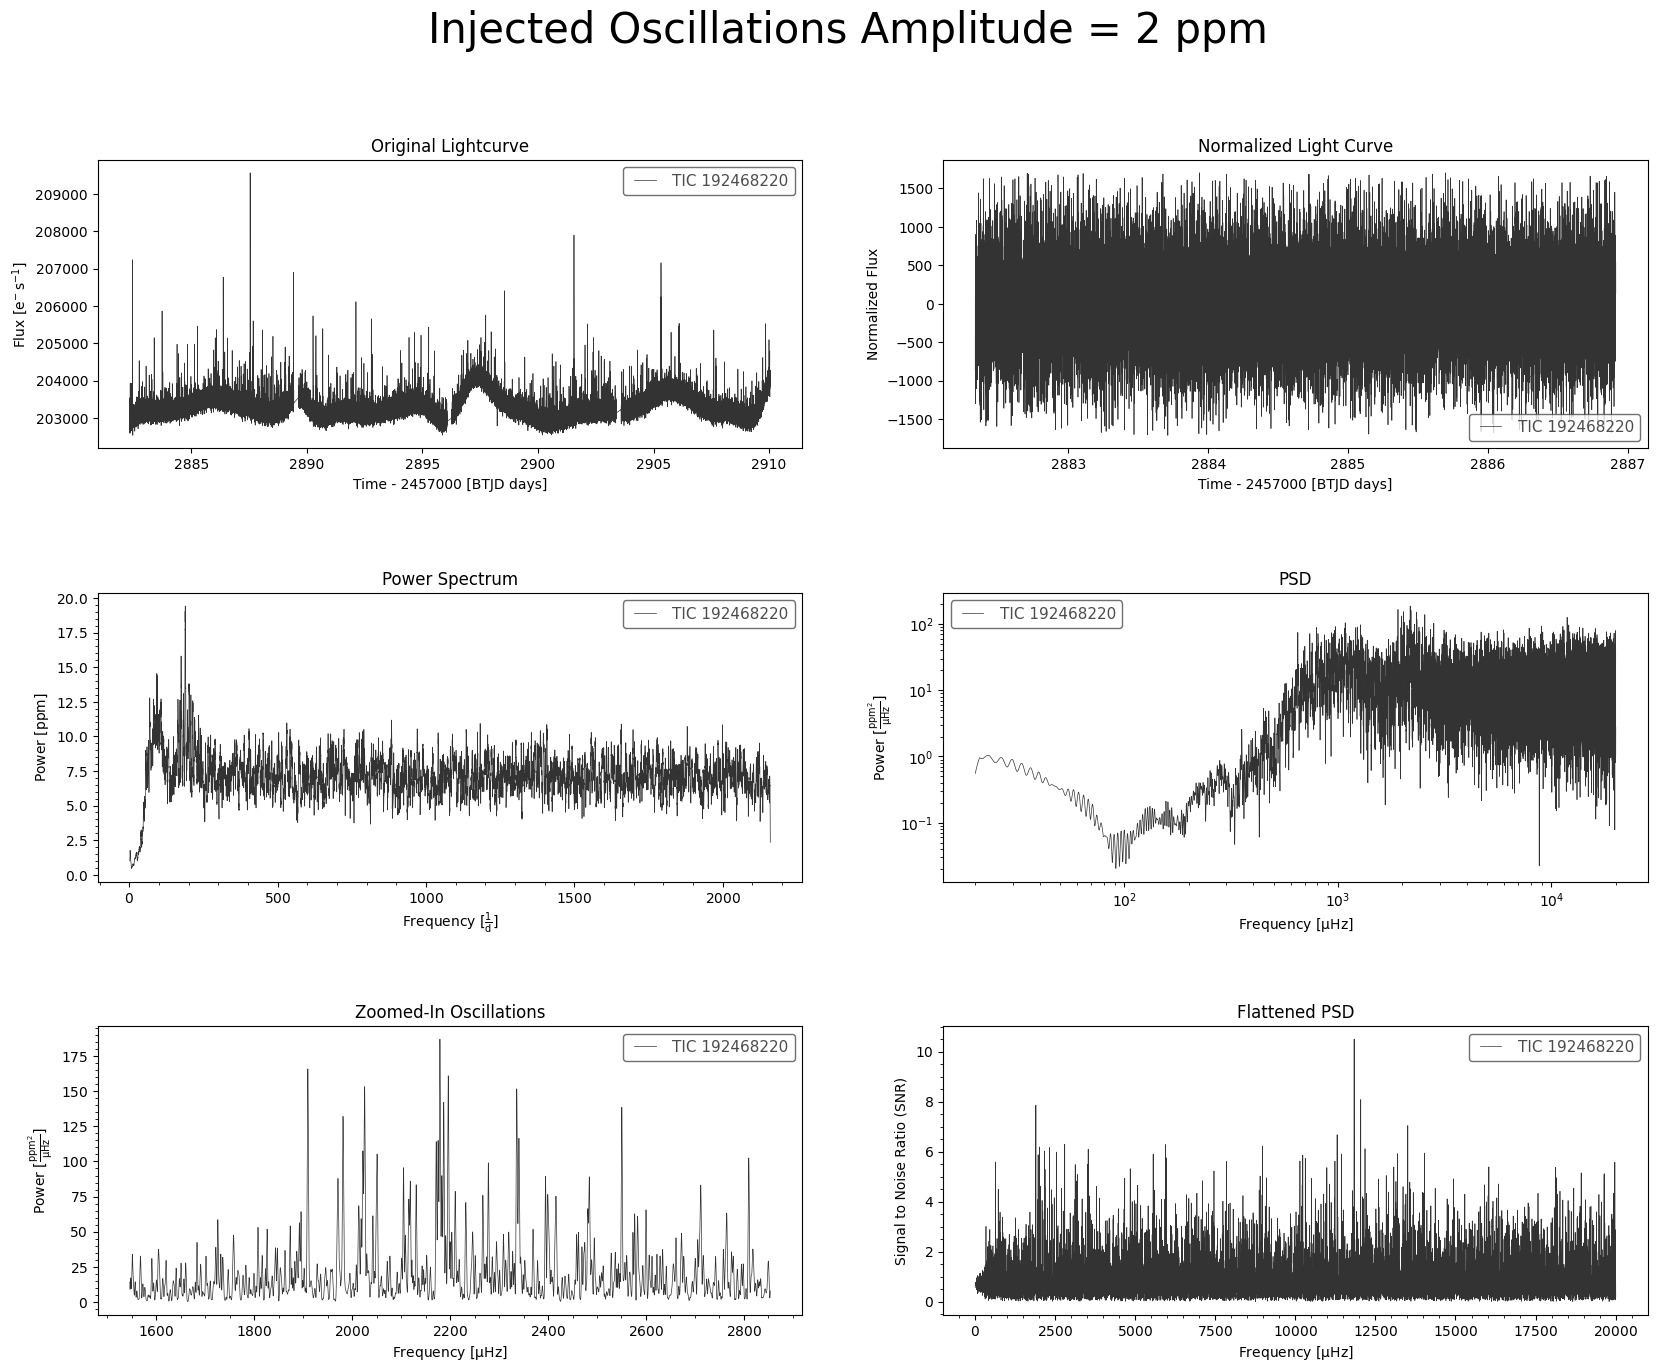

In [365]:
inject_oscillations(2)

In [30]:
search_result = lk.search_lightcurve('HIP 81813',exptime='fast',mission='TESS')
data = search_result.download_all(quality_bitmask="default", flux_column='pdcsap_flux')


In [32]:
lc = data[0]

In [47]:
def get_fwhm(nu_max):
    fwhm = .66 * (nu_max)**.88
    return fwhm

In [51]:
perio.power.value

array([0.5680912 , 0.57883471, 0.58759871, ..., 1.2357132 , 1.22698377,
       1.21764177])

In [53]:
env_start

2599.801937762682

In [60]:
from scipy.stats import chi2

In [94]:
chi2.cdf(1374,1374)

0.5050735733462801

In [110]:
def likelihood_null_hypothesis(power_value, degrees_of_freedom):
    # Calculate the likelihood using the chi-square distribution
    likelihood = chi2.cdf(power_value, degrees_of_freedom)
    print(likelihood)
    return 1-likelihood


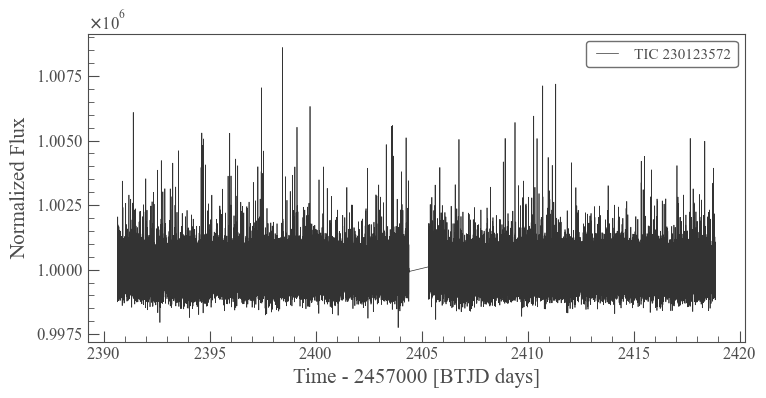

599.6038755253642
PSD SUM 1655.6780755933328


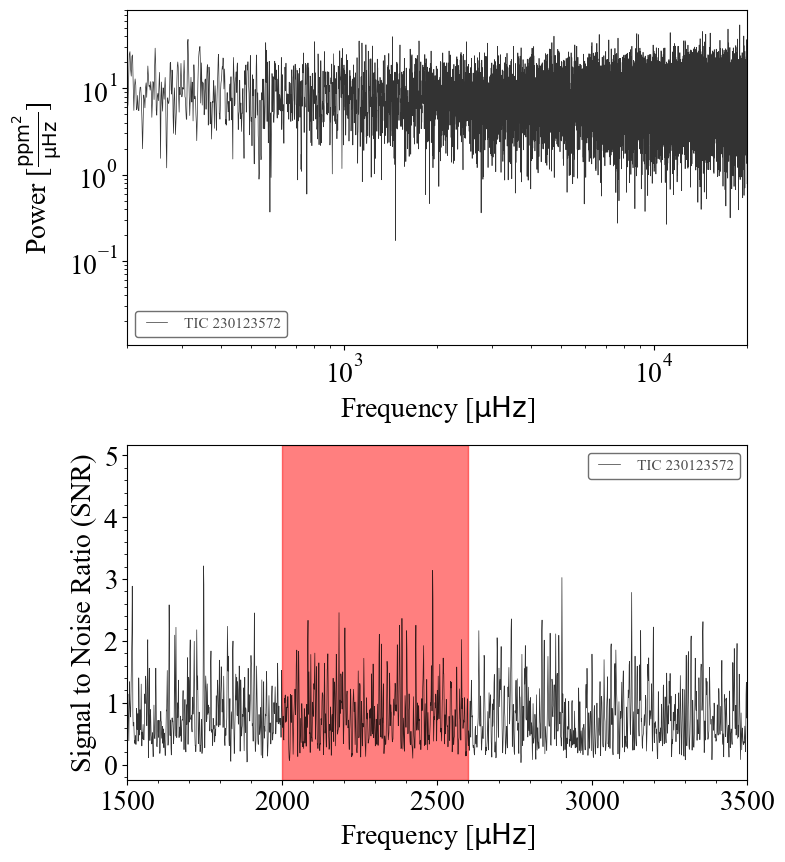

258.1164953839171 288
0.10329588734146956
256.3020760737422 290
0.07643578840541009
256.81074409999474 294
0.05754028172534523
260.7326964119028 296
0.06894125089542183
258.63404433303504 298
0.04826633204101974
261.1532272880274 300
0.051284359145969155
265.0540851353734 304
0.05206943893514822
270.6814345423608 306
0.07222782800867872
268.0512421122236 308
0.048679363159666
269.1419073325981 310
0.04532170711376724
272.25812770305316 314
0.04281722639702996
275.26374838880525 316
0.047561847281857236
272.87857737720526 318
0.031811182574059384
273.42209989673853 320
0.027922659301882594
271.3844784713304 324
0.015223837681024206
270.8618562221356 326
0.011656943822140338
264.5930219664962 328
0.004275539932748237
262.6444430355008 330
0.0025664360897272613
269.0475675364331 334
0.0037794435078523808
267.0946460382939 336
0.0022627046663502314
262.9199718934908 338
0.000941100919258189
265.55620093118443 340
0.0010754869617310573
267.85823326764205 344
0.0008923237834331443
272.810379

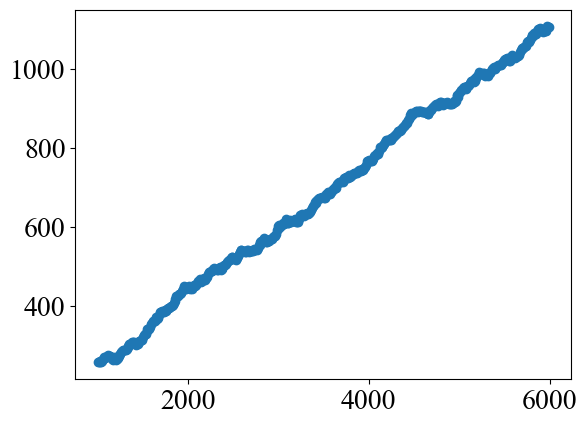

[288.1004492785096, 290.63421771091197, 293.1649774609576, 295.6927615467954, 298.2176023073417, 300.7395314226463, 303.2585799334607, 305.7747782600449, 308.288156220252, 310.79874304692174, 313.3065674046178, 315.81165740573806, 318.31404062602775, 320.81374411952146, 323.31079443294124, 325.80521761957414, 328.2970392526531, 330.78628443826284, 333.27297782779095, 335.7571436299453, 338.2388056223549, 340.71798716277283, 343.1947111998979, 345.6690002838312, 348.1408765761823, 350.61036185983966, 353.0774775484196, 355.54224469540645, 358.0046840029953, 360.46481583065196, 362.9226602033979, 365.37823681983394, 367.83156505991127, 370.2826639924597, 372.7315523824837, 375.178248698233, 377.62277111805867, 380.06513753706054, 382.5053655735357, 384.9434725752339, 387.3794756254281, 389.81339154880567, 392.24523691718883, 394.67502805508747, 397.102781045094, 399.52851173312183, 401.9522357334969, 404.3739684339043, 406.7937250001972, 409.21152038107107, 411.62736931260963, 414.041286

In [125]:
fake_lc,x = get_fake_lc(lc,.5,2001)
psd = fake_lc.to_periodogram(method='lombscargle',frequency=np.arange(1, 20000,1),normalization='psd').smooth(filter_width=2)
perio = fake_lc.to_periodogram(method='lombscargle',frequency=np.arange(2, 2160,0.008)).smooth(filter_width=2)

# heavy_smooth = fake_lc.to_periodogram(method='lombscargle',frequency=np.arange(20, 20000,1),normalization='psd').smooth(filter_width=500)
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 20

fig, ax = plt.subplots(2,1,figsize=(8,10))

psd.plot(scale='log',ax=ax[0],color='black',alpha=.8)
# heavy_smooth.plot(scale='log',ax=ax,color='red')
ax[0].set_xlim(200,20000)

flat = psd.flatten(filter_width=10)
flat.plot(ax=ax[1],color='black',alpha=.8)
ax[1].set_xlim(1500,3500)


nu_max = 2300
fwhm = get_fwhm(nu_max)
print(fwhm)
env_end = int(np.round(nu_max+fwhm/2))
env_start = int(np.round(nu_max-fwhm/2))
ax[1].axvspan(env_start,env_end,color='red',alpha=.5)

print("PSD SUM",sum(perio.power.value[env_start:env_end]))


plt.subplots_adjust(hspace=.3)
plt.show()
# frequency_hz = [(i*10**6)/(24*60*60) for i in np.array(perio.frequency)]
# perio.frequency=frequency_hz*psd.frequency.unit
# perio.plot()

# plt.xlim(1500,3500)


# find max sum

sums = []
likelihoods = []
max_freqs = np.arange(1000,6000,10)
fwhms = []
dofs = []

for freq in max_freqs:
    fwhm = get_fwhm(freq)
    fwhms.append(fwhm)
    env_end = int(np.round(freq+fwhm/2))
    env_start = int(np.round(freq-fwhm/2))
    power_sum = sum(flat.power.value[env_start:env_end])
    sums.append(power_sum)

    num_bins = env_end-env_start
    print(power_sum,num_bins)
    likelihood = likelihood_null_hypothesis(power_sum,num_bins)
    likelihoods.append(likelihood)
    dofs.append(num_bins)

plt.scatter(max_freqs,sums)
plt.show()
print(fwhms)

Text(0.5, 0, 'Max Frequency of Oscillation Envelope')

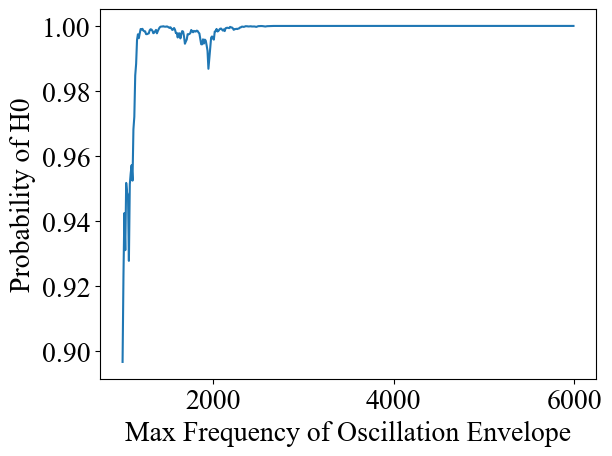

In [126]:
# plt.bar(x=max_freqs,height=likelihoods,width=100)

plt.plot(max_freqs,likelihoods)

plt.ylabel("Probability of H0")
plt.xlabel("Max Frequency of Oscillation Envelope")

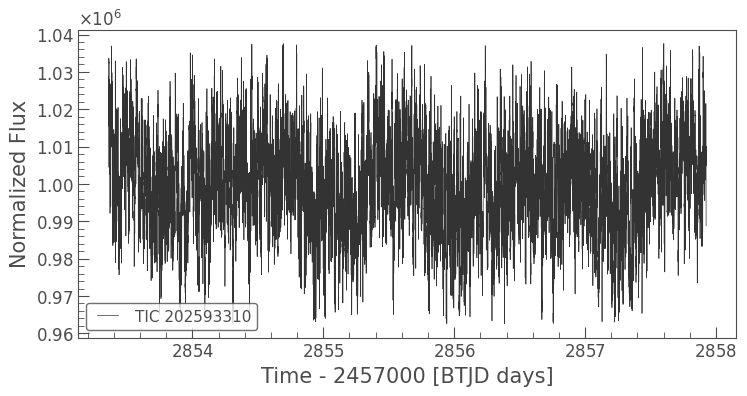

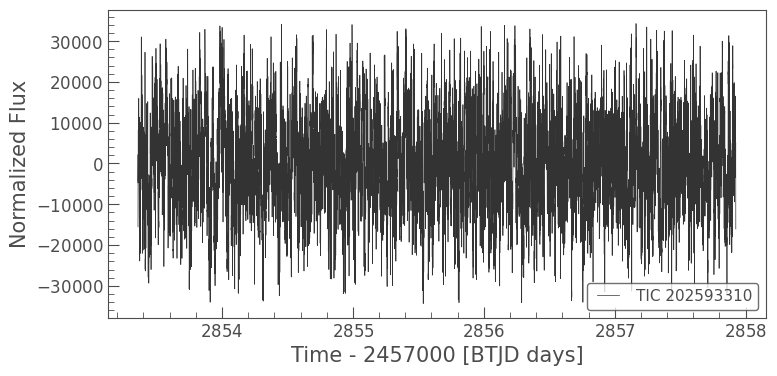

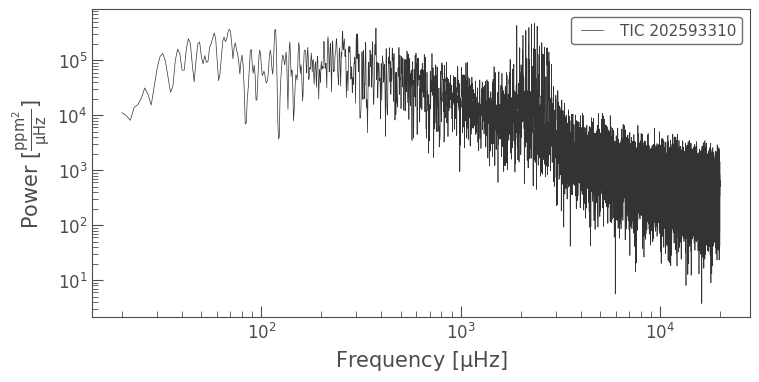

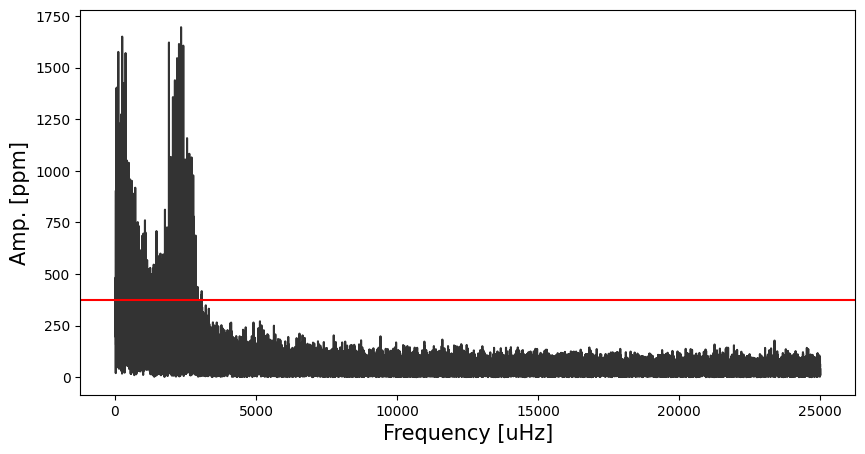

max 65.6481481481482


(LombScarglePeriodogram(ID: TIC 202593310),
 LombScarglePeriodogram(ID: TIC 202593310),
 372.71874792521123)

In [106]:
process(fake_lc.normalize(unit='ppm'),2001)

## AADG Scripts

In [7]:
def get_delta_v(M,R):
    # M and R in units of Solar mass and radius
    return (M)**.5*(R)**(-3/2)*134.9

def get_v_max(M,R,T):
    # T in Kelvin
    return 3050*(M)/((R)**(2)*(T/5777)**.5)

def get_amp():
    s=.748
    r= 3.47
    t=1.27
    b = np.exp(.321)

    

In [18]:
get_delta_v(.6,.62)

214.04251269497243

In [2]:
# masses and temperatures of m dwarfs
m_dwarf_props = pd.read_csv('/Users/caleb/Downloads/data(1).csv',skiprows=3)

In [3]:
m_dwarf_props = m_dwarf_props[:7]
m_dwarf_props

,type,temp ( K ),Unnamed: 2,MS solar masses,MS radius ( solar )
0,MO,3800,""" early """,0.60,0.62
1,M1,3600,NaN,0.49,0.49
2,M2,3400,NaN,0.44,0.44
3,M3,3250,NaN,0.36,0.39
4,M4,3100,NaN,0.20,0.26
5,M5,2800,""" mid """,0.14,0.20
6,M6,2600,NaN,0.10,0.15


In [5]:
masslist = np.arange(.6,-.1,-.1)

In [16]:
spectral_type = []
nu_maxs = []
nu_deltas = []
masses = []
lums = []
amps = []


for index,row in m_dwarf_props.iterrows():
    print(index)
    mtype = row['type']
    temp = row['temp ( K )']

    mass = masslist[index]

    mass = row['MS solar masses']
    radius = row['MS radius ( solar )']

    lum = (radius**2)*(temp/5777)**4
    print(lum)


    amp = 2.1*lum*(1/mass)*(temp/5777)**(-2)

    nu_max = get_v_max(mass,radius,temp)
    delta_nu = get_delta_v(mass,radius)

    spectral_type.append(mtype)
    nu_maxs.append(nu_max)
    masses.append(mass)
    nu_deltas.append(delta_nu)
    lums.append(lum)
    amps.append(amp)

0
0.07196284015509594
1
0.03620701258465311
2
0.023227985752521083
3
0.015235376385288405
4
0.005605108207209975
5
0.002207408174647348
6
0.0009231375987299013


In [17]:
amps

[0.5821218240251188,
 0.3995909477181887,
 0.3200553345417289,
 0.2808070421198662,
 0.20438764874012139,
 0.14094918790765038,
 0.09570701553907866]

In [9]:
oscillation_table = pd.DataFrame({'M' : masses,'Nu' : nu_maxs,'Delta':nu_deltas,'P':nu_deltas})

In [10]:
oscillation_table

,M,Nu,Delta,P
0,0.60,5869.851256,214.042513,214.042513
1,0.49,7885.036222,275.306122,275.306122
2,0.44,9035.639350,306.590909,306.590909
3,0.36,9624.598673,332.327507,332.327507
4,0.20,12318.376561,455.058180,455.058180
5,0.14,15333.456017,564.327188,564.327188
6,0.10,20206.068969,734.302592,734.302592


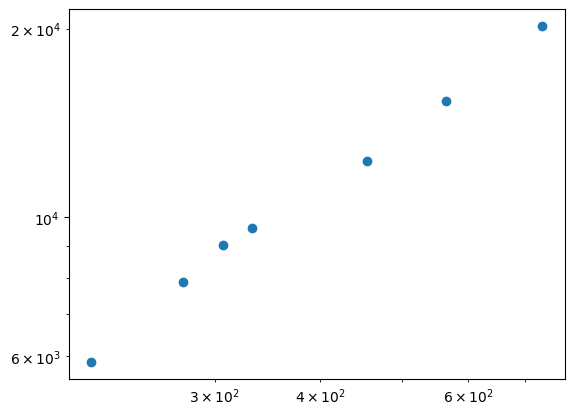

In [550]:
plt.scatter(nu_deltas,nu_maxs)
plt.xscale('log')
plt.yscale('log')

In [524]:
get_delta_v(.934,1.057)

119.97006850025929

In [86]:
get_v_max(.2,.4,3109)

5196.975567757227

In [ ]:
def write_namelist(cadence,n_cadences,relax_days,):
    

In [97]:
from astropy.io import fits

hdul = fits.open('/Users/caleb/Downloads/s4tess_sector_01/00014_01_0001.fits')
hdr = hdul[0].header
print(hdr['NU_MAX'])
hdr['A_RMSMAX'] = np.array(hdr['A_RMSMAX'])*2

data = hdul[2].data
print(max([i[4] for i in data]))
print(data)
print(hdr['A_RMSMAX'])


390.1667091734656
129.44907
[(0,    4, 126.42366, 3.0746416e-02, 6.6738605e-04, 0.       )
 (0,    5, 153.69792, 3.2041320e-02, 7.2710519e-03, 0.       )
 (0,    6, 180.26717, 3.4578034e-02, 5.7977571e-02, 0.       )
 (0,    7, 205.35291, 3.8400987e-02, 3.2815347e-01, 0.       )
 (0,    8, 229.38037, 4.3561409e-02, 1.4042089e+00, 0.       )
 (0,    9, 253.68769, 5.0480993e-02, 4.9754311e+00, 0.       )
 (0,   10, 277.92009, 5.9313408e-02, 1.4293027e+01, 0.       )
 (0,   11, 301.62377, 7.0072731e-02, 3.2888556e+01, 0.       )
 (0,   12, 325.54116, 8.3326420e-02, 6.2466780e+01, 0.       )
 (0,   13, 349.94549, 9.9631901e-02, 9.7787542e+01, 0.       )
 (0,   14, 374.42784, 1.1913125e-01, 1.2432552e+02, 0.       )
 (0,   15, 398.91234, 1.4210535e-01, 1.2814717e+02, 0.       )
 (0,   16, 423.59139, 1.6910679e-01, 1.0683952e+02, 0.       )
 (0,   17, 448.46549, 2.0055871e-01, 7.1686063e+01, 0.       )
 (0,   18, 473.41912, 2.3671156e-01, 3.8642676e+01, 0.       )
 (0,   19, 498.42389, 2.778

In [92]:
from astropy.io import fits

hdul = fits.open('/Users/caleb/Downloads/s4tess_sector_01/07055_01_0673.fits')
hdr = hdul[0].header
print(hdr['NU_MAX'])
print(hdr['A_RMSMAX']**2)
hdr['A_RMSMAX'] = np.array(hdr['A_RMSMAX'])*2
data = hdul[2].data
print(data)

872.712991340024
5.854883326498717
[(0,  3,  205.05273,  0.12581079, 4.1397917e-03, 0.       )
 (0,  4,  246.06535,  0.24163671, 9.8203059e-03, 0.       )
 (0,  5,  287.71985,  0.41978005, 2.2325901e-02, 0.       )
 (0,  6,  329.85215,  0.67494076, 4.8376905e-02, 0.       )
 (0,  7,  373.09138,  1.0270944 , 1.0074054e-01, 0.       )
 (0,  8,  417.52258,  1.4939037 , 2.0092108e-01, 0.       )
 (0,  9,  462.83918,  2.0854083 , 3.8026010e-01, 0.       )
 (0, 10,  508.8343 ,  2.8052106 , 6.7858609e-01, 0.       )
 (0, 11,  555.45225,  3.6509244 , 1.1376932e+00, 0.       )
 (0, 12,  602.67545,  4.6124931 , 1.7866651e+00, 0.       )
 (0, 13,  650.28441,  5.6667636 , 2.6167206e+00, 0.       )
 (0, 14,  697.92641,  6.7789289 , 3.5605596e+00, 0.       )
 (0, 15,  745.22411,  7.9084132 , 4.4934512e+00, 0.       )
 (0, 16,  791.97883,  9.0192362 , 5.2651000e+00, 0.       )
 (0, 17,  838.41393, 10.090402  , 5.7435866e+00, 0.       )
 (0, 18,  885.06797, 11.114761  , 5.8404636e+00, 0.       )
 (0, 

In [80]:
just_osc_lc = lc
just_osc_lc.flux = amp*ascii_grid*ppm_unit


just_osc_lc.plot()
plt.title(f"Scaled by {amp}")
plt.show()
just_osc_lc_perio = just_osc_lc.to_periodogram(method='lombscargle',frequency=np.arange(2, 2160,0.008)).smooth(filter_width=2)
just_osc_lc_perio.plot()
plt.show()


NameError: name 'amp' is not defined

In [47]:
mode_powers = np.array([i[4] for i in data])

Unit("ppm")

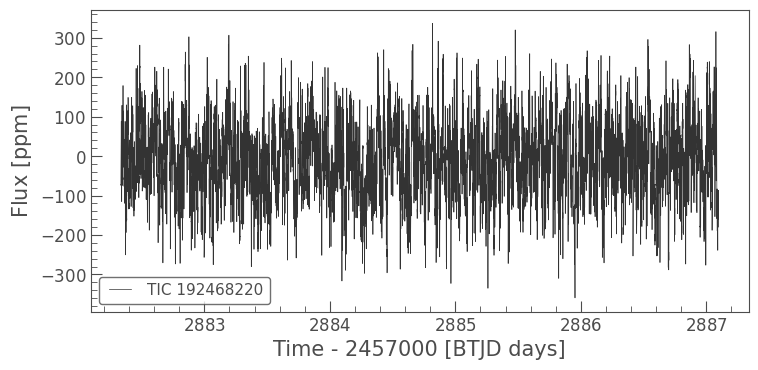

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/astropy/units/quantity.py:613: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


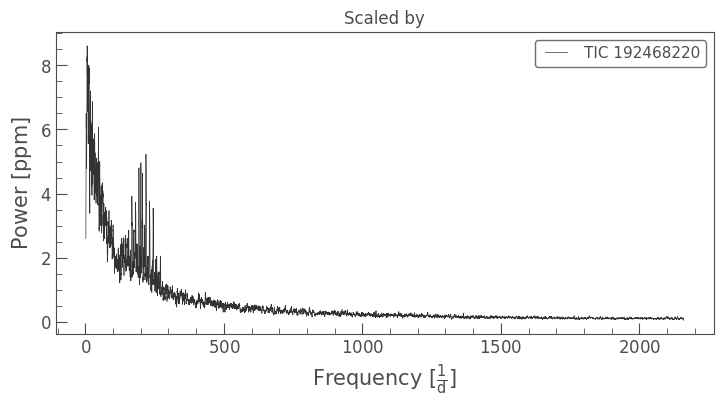

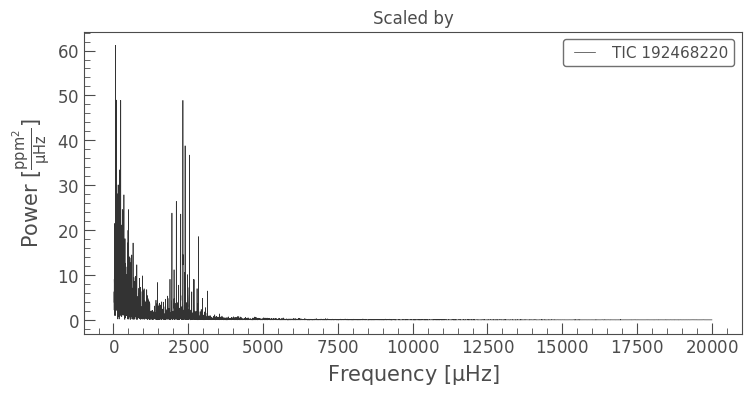

In [98]:
lc_data = hdul[1].data
flux = np.array(lc_data['FLUX'])

just_osc_lc = lc[:len(flux)]
just_osc_lc.flux = flux*lc.normalize(unit='ppm').flux.unit


just_osc_lc.plot()
plt.show()

just_osc_lc_perio = just_osc_lc.to_periodogram(method='lombscargle',frequency=np.arange(2, 2160,0.008)).smooth(filter_width=2)
just_osc_lc_perio.plot()
plt.title(f"Scaled by")

just_osc_lc_perio = just_osc_lc.to_periodogram(method='lombscargle',frequency=np.arange(20, 20000,.1),normalization='psd').smooth(filter_width=2)
just_osc_lc_perio.plot()
plt.title(f"Scaled by")

plt.show()


In [5]:
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

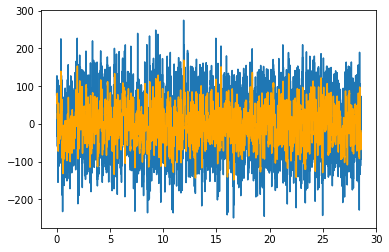

In [6]:
lc_data = hdul[1].data
plt.plot(lc_data['TIME'],lc_data['FLUX'])

flux = np.array(lc_data['FLUX'])
window= 20
avg = moving_average(flux,window)
plt.plot(lc_data['TIME'][window-1:],avg,color='orange')

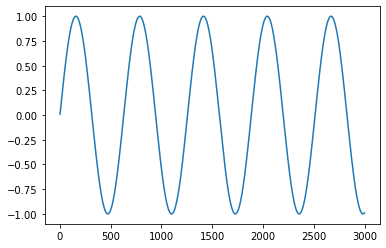

In [ ]:
x=np.arange(1,3000,1)
y= np.sin(1/100*x)
plt.plot(x,y)

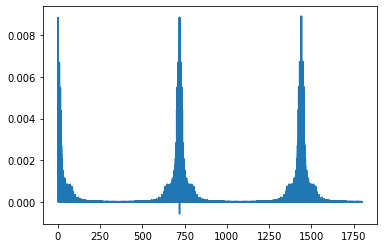

In [8]:
frequency=np.arange(2, 2160,0.001)
frequency,power = LombScargle(lc_data['TIME'],lc_data['FLUX']).autopower()
plt.plot(frequency, power)